In [19]:
import sys, os, math, tempfile, datetime, time, copy, re
import numpy as np
import pandas as pd
from allennlp.commands.elmo import ElmoEmbedder
from collections import Counter, defaultdict
from keras.layers import Input, Dense
from keras.models import Model 
from keras.models import model_from_json
from math import log
from pathlib import Path
import pickle
from scipy.stats import percentileofscore
from sklearn.preprocessing import LabelEncoder
import argparse
import torch
import multiprocessing.pool
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict  
from sklearn.metrics import accuracy_score, auc, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score, recall_score, precision_score

In [20]:
shift, slicesize = 14, 29
path_sequences = "./supporting_file/uniprot_seq.tsv"
df_sequences = pd.read_csv(path_sequences,sep=",")
d_seqs = {}
for index,row in df_sequences.iterrows():
    d_seqs[row["Entry_Isoform"]] = row["Sequence"]

def import_model():
    json_f = open("./models/degron_DL.json", 'r')
    loaded_model_json = json_f.read()
    json_f.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights('./models/degron_DL.h5')
    return loaded_model

def AA_encoding(seq_extended):
    amino = "ABCDEFGHIJKLMNOPQRSTUVWXYZ-"
    encoder = LabelEncoder()
    encoder.fit(list(amino))
    seq_transformed = np.array(
        list(map(encoder.transform, np.array([list(i.upper()) for i in seq_extended]))))   
    return seq_transformed[0]

def calculate_metrics(gt, pred_score):
        
    scores_two = np.array([[1-s, s] for s in pred_score])
    pred = np.argmax(scores_two,axis = 1)

    confusion = confusion_matrix(gt, pred)

    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    P = TP / float(TP + FP)
    R = TP / float(TP + FN)

    auc = roc_auc_score(gt,pred_score)
    PPV = TP / float(TP + FP)
    accuracy = accuracy_score(gt,pred)
    recal = recall_score(gt,pred)
    precision = precision_score(gt,pred)
    F1_score = (2*recal*precision)/(recal+precision)
    auprc = average_precision_score(gt,pred_score)
    
    return auc, auprc, accuracy, recal, F1_score

In [21]:
class Elmo_embedder():
    def __init__(self, model_dir="./models/uniref50_v2", weights="weights.hdf5",
                 options="options.json", threads=100): 
        if threads == 100:
            torch.set_num_threads(multiprocessing.cpu_count() // 2)
        else:
            torch.set_num_threads(threads)

        self.model_dir = Path(model_dir)
        self.weights = self.model_dir / weights
        self.options = self.model_dir / options
        self.seqvec = ElmoEmbedder(self.options, self.weights, cuda_device=-1)

    def elmo_embedding(self, x, start=None, stop=None):
        assert start is None and stop is None, "deprecated to use start stop, please trim seqs beforehand"

        if type(x[0]) == str:
            x = np.array([list(i.upper()) for i in x])
        embedding = self.seqvec.embed_sentences(x)
        X_parsed = []
        for i in embedding:
            X_parsed.append(i.mean(axis=0))
        return X_parsed
    
elmo_embedder = Elmo_embedder(threads=60)   
loaded_model = import_model() 

### Predicting E3 ligase targeted degrons using deep learning

In [22]:
test_file = './data/test_properties.tsv'
df_matches = pd.read_csv(test_file, sep="\t")

X_local, all_seq_transformed, all_seq_elmo_embedding = [], [], []
m = 0
for index,row in df_matches.iterrows():
    m = m + 1
    seq_local = d_seqs[row['Entry']]
    seq_len = len(seq_local)
    seq_local = seq_local.upper()
    seq_local_list = np.array(list(seq_local))

    X_embedding = elmo_embedder.elmo_embedding(seq_local_list)
    protein_pad_global = np.zeros((seq_len + (shift * 2), 1024), dtype=np.float32)

    for i in range(0, seq_len, 1):
        protein_pad_global[i + (shift)] = X_embedding[i]

    protein_pad_local = ["-"] * (seq_len + (shift * 2))
    for i in range(0, seq_len, 1):
        protein_pad_local[i + (shift)] = seq_local[i]
    protein_pad_local = "".join(protein_pad_local)

    start_origin = int(row['Start'])-1
    stop_origin = int(row['End'])
    motif = row['DEGRON']
    degron = row['Hit']
    start = start_origin + shift
    stop = stop_origin + shift
    median_pos = (start+stop-1)//2
    slice_start = median_pos - slicesize // 2
    slice_stop = slice_start + slicesize
    query_seq = protein_pad_local[slice_start:slice_stop]
    seq_transformed = AA_encoding([query_seq])
    all_seq_transformed.append(seq_transformed)
    seq_elmo_embedding = protein_pad_global[slice_start:slice_stop]
    all_seq_elmo_embedding.append(seq_elmo_embedding)
    
    print(m)
    
probs_p = loaded_model.predict([all_seq_elmo_embedding, all_seq_transformed]) 
probs_p1 = [float(i) for i in probs_p]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [25]:
simulated = './supporting_file/simulated_degron2.csv'
df_simulated = pd.read_csv(simulated)

results = []
for s in range(10):
    df_simulated_s = df_simulated.sample(n=len(df_matches), random_state=s+1)
    X_local, all_seq_transformed, all_seq_elmo_embedding = [], [], []
    m = 0
    for index,row in df_simulated_s.iterrows():
        m = m + 1
        seq_local = d_seqs[row['Entry']]
        seq_len = len(seq_local)
        seq_local = seq_local.upper()
        seq_local_list = np.array(list(seq_local))

        X_embedding = elmo_embedder.elmo_embedding(seq_local_list)
        protein_pad_global = np.zeros((seq_len + (shift * 2), 1024), dtype=np.float32)

        for i in range(0, seq_len, 1):
            protein_pad_global[i + (shift)] = X_embedding[i]

        protein_pad_local = ["-"] * (seq_len + (shift * 2))
        for i in range(0, seq_len, 1):
            protein_pad_local[i + (shift)] = seq_local[i]
        protein_pad_local = "".join(protein_pad_local)

        start_origin = int(row['START'])-1
        stop_origin = int(row['END'])
        motif = row['DEGRON']
        start = start_origin + shift
        stop = stop_origin + shift
        median_pos = (start+stop-1)//2
        slice_start = median_pos - slicesize // 2
        slice_stop = slice_start + slicesize
        query_seq = protein_pad_local[slice_start:slice_stop]
        seq_transformed = AA_encoding([query_seq])
        all_seq_transformed.append(seq_transformed)
        seq_elmo_embedding = protein_pad_global[slice_start:slice_stop]
        all_seq_elmo_embedding.append(seq_elmo_embedding)
                
    print(s)
    
    probs_n = loaded_model.predict([all_seq_elmo_embedding, all_seq_transformed]) 
    probs_n1 = [float(i) for i in probs_n]
    
    predicted_probs = np.concatenate((probs_p1,probs_n1)) 
    true_labels = np.concatenate((np.ones((len(probs_p1),), dtype=np.int),np.zeros((len(probs_n1),), dtype=np.int)), axis=0)
    
    temp={"predicted_probs" : predicted_probs,
            "true_labels" : true_labels,
            "symbol" : 'test_n%s' % str(s+1),
            }
    temp1=pd.DataFrame(temp)
    
    results.append(temp1)
    
df_result_metadegron_d = pd.concat(results, ignore_index=True)

0


/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


1
2
3
4
5
6
7
8
9


### Predicting E3 ligase targeted degrons using XGBoost model trained on multimodal feature 

In [26]:
classifier_XGBoost  = "./models/classifier_XGBoost.pickle"
out_file = './prediction'
test_data = './data/test_properties.tsv'
df_properties = pd.read_csv(test_data, sep="\t")

covariates = ['solvent_accessibility', 'disorder', 'conservative_score', 'coiled_coil',
              'anchoring_score', 'flanking_ptms', 'flanking_ub_lysine', 
              'a_helix', 'flexibility',  'structured_domain',  ]

pred =["ASA_SCORE","DSS_SCORE","FCONS_SCORE","COIL",
       "ANCHOR_SCORE","nflanking_ptms","nflanking_ub_lysines",
       "HELIX","RIG_SCORE","Domain_pfam"]

clf = pickle.load(open(classifier_XGBoost, "rb"))
p_probs = clf.predict_proba(df_properties[covariates])
probs_p1 = [l[1] for l in p_probs]

In [28]:
simulated = './supporting_file/simulated_degron2.csv'
df_simulated = pd.read_csv(simulated)
results = []
for s in range(10):
    df_simulated_s = df_simulated.sample(n=len(probs_p1), random_state=s+1)
    negatives = df_simulated_s.copy()
    n_probs = clf.predict_proba(negatives[pred])
    probs_n1 = [l[1] for l in n_probs]

    predicted_probs = np.concatenate((probs_p1,probs_n1)) 
    true_labels = np.concatenate((np.ones((len(probs_p1),), dtype=np.int),np.zeros((len(probs_n1),), dtype=np.int)), axis=0)
    
    temp={"predicted_probs" : predicted_probs,
            "true_labels" : true_labels,
            "symbol" : 'test_n%s' % str(s+1),
            }
    temp1=pd.DataFrame(temp)
    
    results.append(temp1)
    
df_result_metadegron_x = pd.concat(results, ignore_index=True)

/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


In [33]:
df_result_metadegron_x

,predicted_probs,true_labels,symbol
0,0.634291,1,test_n1
1,0.400620,1,test_n1
2,0.788356,1,test_n1
3,0.709616,1,test_n1
4,0.844616,1,test_n1
...,...,...,...
395,0.053297,0,test_n10
396,0.148690,0,test_n10
397,0.059582,0,test_n10
398,0.040879,0,test_n10


In [34]:
results = []
filefold = './supporting_file/Degpred_result.csv'
Degpred_RES = pd.read_csv(filefold)

for symbol, grp in Degpred_RES.groupby("symbol"):
    auc, auprc, accuracy, recal, F1_score = calculate_metrics(grp['true_labels'], grp['predicted_probs'])
    results.append([auc, 'auc', symbol])
    results.append([auprc, 'auprc', symbol])
    results.append([accuracy, 'accuracy', symbol])
    results.append([recal, 'recall', symbol])
    results.append([F1_score, 'F1_score', symbol])
    
Degpred_pred=pd.DataFrame(results, columns=['values','metrics','times'])   
Degpred_pred['tools'] = 'Degpred' 

results = []
for symbol, grp in df_result_metadegron_d.groupby("symbol"):
    auc, auprc, accuracy, recal, F1_score = calculate_metrics(grp['true_labels'], grp['predicted_probs'])
    results.append([auc, 'auc', symbol])
    results.append([auprc, 'auprc', symbol])
    results.append([accuracy, 'accuracy', symbol])
    results.append([recal, 'recall', symbol])
    results.append([F1_score, 'F1_score', symbol])
    
MetaDegron_D_pred=pd.DataFrame(results, columns=['values','metrics','times'])   
MetaDegron_D_pred['tools'] = 'MetaDegron-D' 

results = []
for symbol, grp in df_result_metadegron_x.groupby("symbol"):
    auc, auprc, accuracy, recal, F1_score = calculate_metrics(grp['true_labels'], grp['predicted_probs'])
    results.append([auc, 'auc', symbol])
    results.append([auprc, 'auprc', symbol])
    results.append([accuracy, 'accuracy', symbol])
    results.append([recal, 'recall', symbol])
    results.append([F1_score, 'F1_score', symbol])
    
MetaDegron_X_pred=pd.DataFrame(results, columns=['values','metrics','times'])   
MetaDegron_X_pred['tools'] = 'MetaDegron-X' 

df_pred = pd.concat([Degpred_pred, MetaDegron_D_pred, MetaDegron_X_pred])


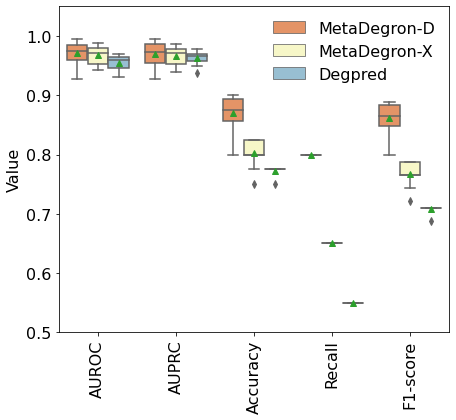

In [35]:
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=7, 6
figure, ax = plt.subplots(figsize=figsize)
plt.tick_params(labelsize=16)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels] 

sns.boxplot(x="metrics", y="values", hue='tools',
                order=['auc','auprc','accuracy','recall','F1_score'],
                hue_order=['MetaDegron-D','MetaDegron-X','Degpred'],
                data=df_pred, palette='RdYlBu',showmeans=True)

plt.xlabel('', font1, fontsize=16) 
plt.ylabel('Value', font1, fontsize=16)
plt.xticks(rotation=90)
ax.set_ylim(0.5,1.05)
ax.set_xticklabels(["AUROC", "AUPRC", "Accuracy", "Recall", "F1-score"])
plt.legend(frameon=False, prop=font1)
